In [1]:
import pandas as pd
import numpy as np
import torch
from torch.utils.data import DataLoader, TensorDataset

In [2]:
import random

# Фиксирую случайность 

def seed_all(seed_value=42):
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)
    
# seed_all()

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
from sklearn.preprocessing import LabelEncoder

# Добавляю столбцы с лейблами для каждой категории
def encode_columns(data, columns):
    encoders = []
    labels = []
    for column in columns:
        le = LabelEncoder()
        data[f'label_{column}'] = le.fit_transform(data[column].values)
        encoders.append(le)
        labels.append(f'label_{column}')
        
    return data, encoders, labels

column_to_encode = [
                    'is_ethicity_superior_meaning',
                   'is_ethicity_aggressor_meaning',
                   'is_ethicity_dangerous_meaning'
                    ]

# data, encoders, labels = encode_columns(data, column_to_encode)

In [5]:
from sklearn.feature_extraction.text import CountVectorizer
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

from collections import Counter
from gensim.models import Word2Vec

import transformers
from transformers import BertModel
from transformers import BertTokenizer
from transformers import AdamW, get_linear_schedule_with_warmup
from sklearn.metrics import classification_report, confusion_matrix

import time

2023-06-21 00:03:41.588936: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-21 00:03:42.060186: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [6]:
from tqdm import tqdm_notebook

# Перевожу текст в токены длины не больше seq_len
def Tokenize(column, seq_len):
    corpus = [word for text in column for word in text.split()]
    count_words = Counter(corpus)
    sorted_words = count_words.most_common()
    vocab_to_int = {w:i+1 for i, (w,c) in enumerate(sorted_words)}

    text_int = []
    for text in column:
        r = [vocab_to_int[word] for word in text.split()]
        text_int.append(r)
    features = np.zeros((len(text_int), seq_len), dtype = int)
    for i, review in enumerate(text_int):
        if len(review) <= seq_len:
            zeros = list(np.zeros(seq_len - len(review)))
            new = zeros + review
        else:
            new = review[: seq_len]
        features[i, :] = np.array(new)

    return sorted_words, features

# Создаю матрицу эмбеддингов
def get_embedding_matrix(vocabulary, navec, vocab_size=500003, embedding_dim=300):

    embedding_matrix = np.zeros((vocab_size, embedding_dim))

    for word, token in tqdm_notebook(vocabulary):
        if word in navec.vocab.words:
            embedding_vector = navec[word]
            embedding_matrix[token] = embedding_vector

    return embedding_matrix

In [7]:
def is_classes_whole(df, labels):
    
    if len(df) < 200:
        return False
    
    for label in labels:
        unique_classes, counts = np.unique(df[label].values, return_counts=True)
        if len(unique_classes) != 3 or counts.min() < 3:
            return False
        
    return True

In [8]:
from torch import optim, nn, utils, Tensor
import pytorch_lightning as pl
import torch.nn as nn
from torcheval.metrics.functional import multiclass_f1_score

# Cлой внимания
class Attention(nn.Module):
    def __init__(self, hidden_dim):
        super().__init__()
        self.attn = nn.Linear(256, 256)
        self.v = nn.Linear(256, 1, bias=False)

    def forward(self, hidden, encoder_outputs):
        seq_len = encoder_outputs.size(1)
        hidden = hidden[-1]
        hidden_repeated = hidden.unsqueeze(1).repeat(1, seq_len, 1)
        attn_weights = torch.tanh(self.attn(torch.cat((hidden_repeated, encoder_outputs), dim=2)))
        attn_weights = self.v(attn_weights).squeeze(2)
        return nn.functional.softmax(attn_weights, dim=1)

# Модель
class LSTMModel(pl.LightningModule):
    def __init__(self, input_dim, labels, head_dims):
        super().__init__()     

#         self.fc1 = nn.Linear(input_dim, 256)
        self.embedding = nn.Embedding(VOCAB_SIZE, EMBEDDING_DIM)

        self.lstm = nn.LSTM(input_size=300, hidden_size=128, num_layers=1, batch_first=True)
        self.attention = Attention(128)
        self.fc2 = nn.Linear(128, 64)
        
        self.heads = nn.ModuleList()
        self.loss_fns = []
        for i, label in enumerate(labels):
            head = nn.Linear(64, head_dims[i]).cuda()
            self.heads.append(head)
            
            loss_fn = nn.CrossEntropyLoss()
            self.loss_fns.append(loss_fn)
        
        self.dropout = nn.Dropout(0.5)
        self.relu = nn.ELU()
    
        self.labels = labels
        self.head_dims = head_dims
    
    def training_step(self, batch, batch_idx):
        x, y = batch
#         label1, label2 = y[:, 0], y[:, 1]

        x = self.forward(x)
        
        losses = []
        for i, label in enumerate(self.labels):
            loss = self.loss_fns[i](x[i], y[:, i])
            self.log(f'train_loss_head_{i}', loss, prog_bar=True, on_step=False, on_epoch=True)
            losses.append(loss)
            
        loss = sum(losses)
        
        self.log("train_loss", loss, prog_bar=True, on_step=False, on_epoch=True)
        return loss
        
    def validation_step(self, batch, batch_idx):
        x, y = batch
#         label1, label2 = y[:, 0], y[:, 1]
        
        x = self.forward(x)
        losses = []
        for i, label in enumerate(self.labels):
            loss = self.loss_fns[i](x[i], y[:, i])
            self.log(f'val_loss_head_{i}', loss, prog_bar=False, on_step=False, on_epoch=True)
            losses.append(loss)
            
        loss = sum(losses)
                
        self.log("val_loss", loss, prog_bar=True, on_step=False, on_epoch=True)

        def log_f1_score(raw_preds, targets, name, num_classes):
            preds = torch.argmax(raw_preds, dim=-1)
            f1_acc = multiclass_f1_score(preds, targets, num_classes=num_classes, average='macro', )
            self.log(f'f1_score_{name}', f1_acc, prog_bar=True, on_step=False, on_epoch=True)
            return f1_acc
        
        scores = []
        for i, label in enumerate(self.labels): 
            f1_acc = log_f1_score(x[i], y[:, i], f'head_{i}', self.head_dims[i])
            scores.append(f1_acc)
            
        scores = torch.tensor(scores).mean()
        self.log(f'f1_score_mean', scores, prog_bar=False, on_step=False, on_epoch=True)
        
        
    def forward(self, x):
        x = self.embedding(x)
        out, hidden = self.lstm(x)
        out = self.dropout(out)
        
        self.out = out
        attn_weights = self.attention(hidden[0], out)
        self.attn_weights = attn_weights
        # Calculate context vector by taking the weighted sum of LSTM outputs
        context = attn_weights.unsqueeze(1).bmm(out).squeeze(1)
        self.context = context
        x = self.relu(self.dropout(self.fc2(context)))
            
#         x = self.relu(self.dropout(self.fc2(x)))
        
        return [head(x) for head in self.heads]

    def configure_optimizers(self):
        optimizer = optim.AdamW(self.parameters(), lr=2e-3, weight_decay=5e-6)
#         optimizer = optim.RMSprop(self.parameters(), lr=2e-3)
        return optimizer


In [9]:
import os

os.environ["TOKENIZERS_PARALLELISM"] = "false"
torch.set_float32_matmul_precision('high')

In [10]:
from sklearn.metrics import f1_score, classification_report, confusion_matrix, accuracy_score

# Получаю предсказания
def get_predictions(model, test_loader, labels):
    
    predictions = torch.zeros_like(test_loader.dataset.tensors[1])
    
    for i, item in enumerate(test_loader.dataset):
        x, y = item
        preds = model(x.unsqueeze(0).cpu())
        predictions[i] = torch.cat([one_pred.argmax(1) for one_pred in preds])
        
    scores = []
    accuracy_scores = []
    for i in range(predictions.shape[1]):
        scores.append(f1_score(test_loader.dataset.tensors[1][:, i], predictions[:, i], average='macro'))
        accuracy_scores.append(accuracy_score(test_loader.dataset.tensors[1][:, i], predictions[:, i]))

    classification_reports = []
    confusion_matrices = []
        
    for k in range(len(labels)):
        report = classification_report(test_loader.dataset.tensors[1][:, k], predictions[:, k])
        classification_reports.append(report)
        
        matrix = confusion_matrix(test_loader.dataset.tensors[1][:, k], predictions[:, k])
        confusion_matrices.append(matrix)
        
    
    
    return {'predictions': predictions,
            'scores': scores,
            'classification_reports': classification_reports,
            'confusion_matrices': confusion_matrices,
            'accuracy_scores': accuracy_scores
           }


In [11]:
from pytorch_lightning.callbacks.early_stopping import EarlyStopping

early_stop_callback = EarlyStopping(monitor="f1_score_mean", min_delta=0.00, patience=2, verbose=False, mode="max")

In [12]:
from navec import Navec
import os

# Загружаю модель с эмбеддингами

try:
    path = 'navec_hudlit_v1_12B_500K_300d_100q.tar'
    navec = Navec.load(path)
except:
    os.system('wget https://storage.yandexcloud.net/natasha-navec/packs/navec_hudlit_v1_12B_500K_300d_100q.tar')
    path = 'navec_hudlit_v1_12B_500K_300d_100q.tar'
    navec = Navec.load(path)

In [13]:
from IPython.display import clear_output
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler
    
    
cols = [
        'label_is_ethicity_superior_meaning',
        'label_is_ethicity_aggressor_meaning',
        'label_is_ethicity_dangerous_meaning'   
]

# Инициализирую даталоадеры для обучения
def get_dataloaders(X, y, is_balanced, seed_value):
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15,
                                                        stratify=y[:, -1], random_state=seed_value)
    X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.15,
                                                          stratify=y_train[:, -1], random_state=seed_value)
    

    if is_balanced:
        # Over third col as its most imbalanced
        ros = RandomOverSampler()
        indices = np.arange(len(X_train)).reshape(-1, 1)
        indices_os, _ = ros.fit_resample(indices, np.array(y_train[:, -1]))
        X_train, y_train = X_train[indices_os.flatten()], y_train[indices_os.flatten()]

    
    train_data = TensorDataset(torch.from_numpy(X_train), torch.from_numpy(y_train))
    test_data = TensorDataset(torch.from_numpy(X_test), torch.from_numpy(y_test))
    valid_data = TensorDataset(torch.from_numpy(X_valid), torch.from_numpy(y_valid))
        
        
    train_loader = DataLoader(train_data, shuffle=True, batch_size=32, drop_last=True, num_workers=12) 
    valid_loader = DataLoader(valid_data, shuffle=False, batch_size=32, drop_last=True, num_workers=12)
    test_loader = DataLoader(test_data, shuffle=False, batch_size=32, drop_last=True, num_workers=12)
    
    return train_loader, valid_loader, test_loader

In [14]:
all_results = []

In [17]:
for seed_value in range(1):
    seed_all(seed_value)

    data = pd.read_csv('../data/is_ethicity_superior_meaning|is_ethicity_aggressor_meaning|is_ethicity_dangerous_meaning_eth_group_lemm_text.csv')
    data['text_len'] = [len(text.split()) for text in data['lemm_text']]
    data, encoders, labels = encode_columns(data, column_to_encode)

    max_len = np.max(data['text_len'])
    vocabulary, tokenized_column = Tokenize(data['lemm_text'], max_len)
    embedding_matrix = get_embedding_matrix(vocabulary, navec)

    X = tokenized_column
    y = data[labels].values

    VOCAB_SIZE = len(navec.vocab.words) + 1
    EMBEDDING_DIM = 300

    train_loader, valid_loader, test_loader = get_dataloaders(X, y,
                                            is_balanced=False, seed_value=seed_value)

    model = LSTMModel(input_dim=100, labels=labels, head_dims=[3, 3, 3])
    model.embedding.weight.data.copy_(torch.from_numpy(embedding_matrix))
    model.embedding.weight.requires_grad = True

    early_stop_callback = EarlyStopping(monitor="f1_score_mean", min_delta=0.00, patience=2, verbose=False, mode="max")
    trainer = pl.Trainer(max_epochs=20, callbacks=[early_stop_callback])
    trainer.fit(model=model, train_dataloaders=train_loader, val_dataloaders=valid_loader)

    model.eval()
    scores = get_predictions(model, test_loader, labels)

#         all_results.append(scores)
#         torch.save(model, f'lstm_model_seed={seed_value}')
#     one_head_results.append(scores)
# all_results.append(one_head_results)
    

/tmp/ipykernel_1774218/3130916548.py:30: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for word, token in tqdm_notebook(vocabulary):


  0%|          | 0/38654 [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type       | Params
-----------------------------------------
0 | embedding | Embedding  | 150 M 
1 | lstm      | LSTM       | 220 K 
2 | attention | Attention  | 66.0 K
3 | fc2       | Linear     | 8.3 K 
4 | heads     | ModuleList | 585   
5 | dropout   | Dropout    | 0     
6 | relu      | ELU        | 0     
-----------------------------------------
150 M     Trainable params
0         Non-trainable params
150 M     Total params
601.184   Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

In [296]:
for item in test_loader:
    x = torch.tensor(tokenized_column[:1000])
    model(x)
    break

In [338]:
data[column_to_encode].iloc[k]

is_ethicity_superior_meaning      irrel
is_ethicity_aggressor_meaning    victim
is_ethicity_dangerous_meaning        no
Name: 115, dtype: object

In [281]:
a = model.out[0].sum(dim=0).detach().numpy()
a = (a - a.min()) / (a.max() - a.min()) - 1/2

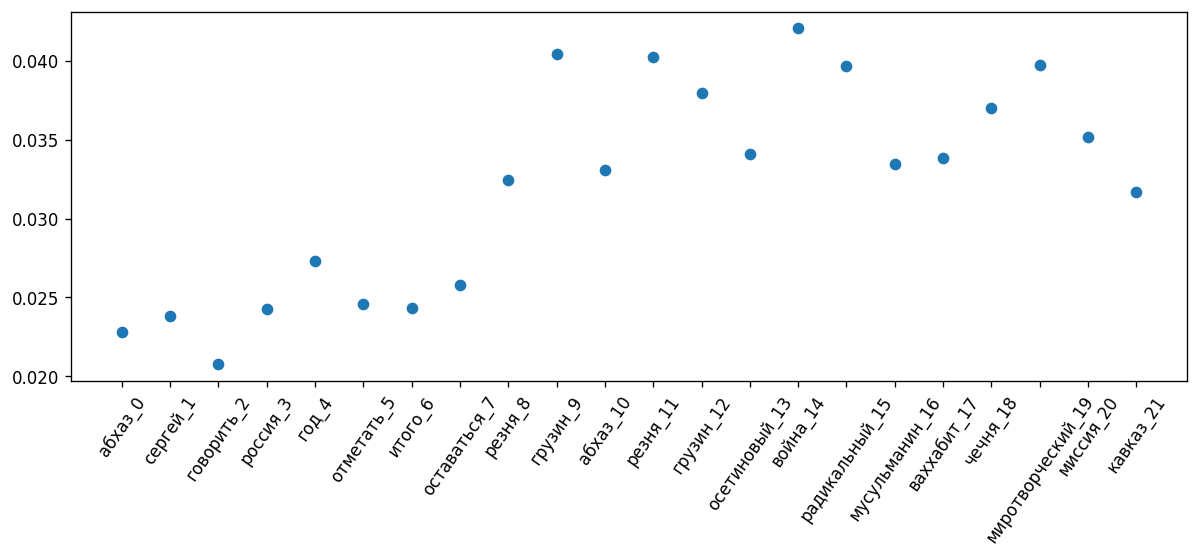

In [340]:
plt.figure(figsize=(12, 4), dpi=120)
k = 115
x_labels = data['lemm_text'][k].split(' ')
x_labels = [f'{item}_{i}' for i, item in enumerate(x_labels)]

plt.plot(x_labels, model.attn_weights[k].detach().numpy()[-len(x_labels):], 'o')
# plt.plot(model.attn_weights[k].detach().numpy(), 'o')
plt.xticks(rotation=55)
pass

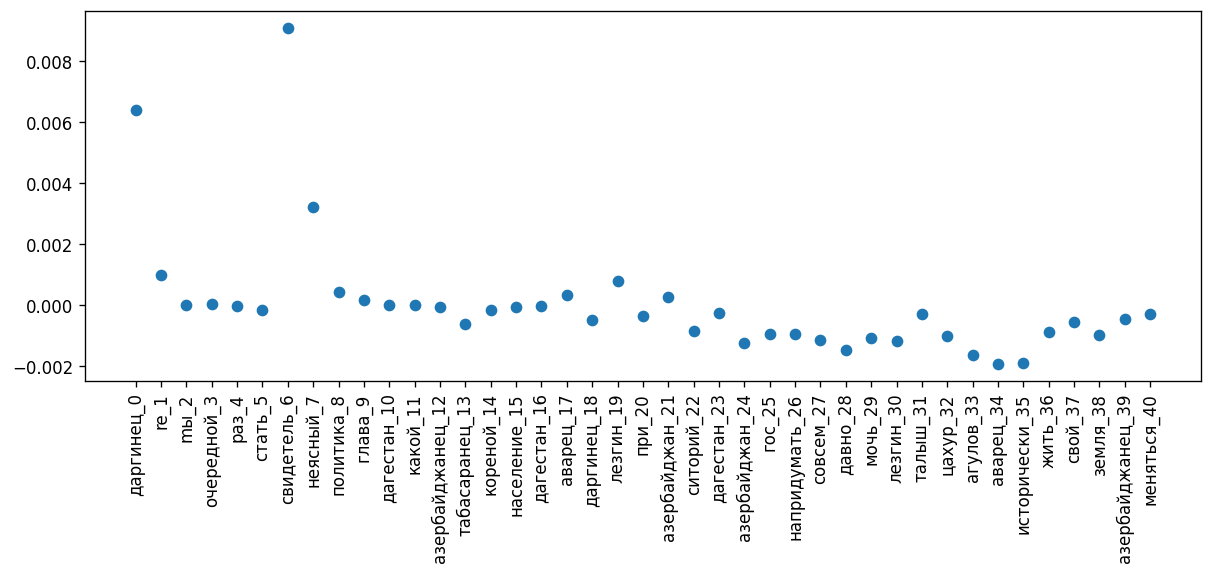

In [320]:
plt.figure(figsize=(12, 4), dpi=120)
k = 500
x_labels = data['lemm_text'][k].split(' ')
x_labels = [f'{item}_{i}' for i, item in enumerate(x_labels)]

plt.plot(x_labels, model.attn_weights[k].detach().numpy()[-len(x_labels):] - model.attn_weights[k - 1].detach().numpy()[-len(x_labels):], 'o')
# plt.plot(model.attn_weights[k].detach().numpy(), 'o')
plt.xticks(rotation=90)
pass

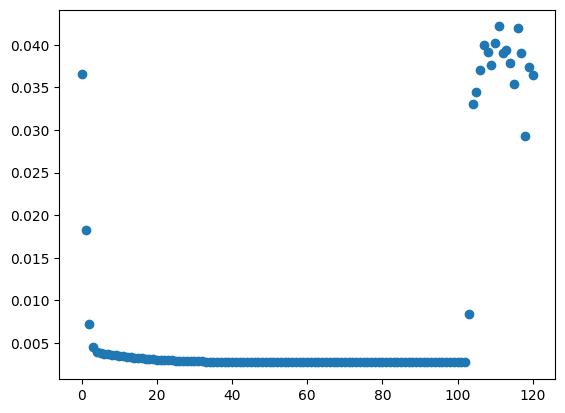

In [251]:
plt.plot(model.attn_weights[k].detach().numpy(), 'o')

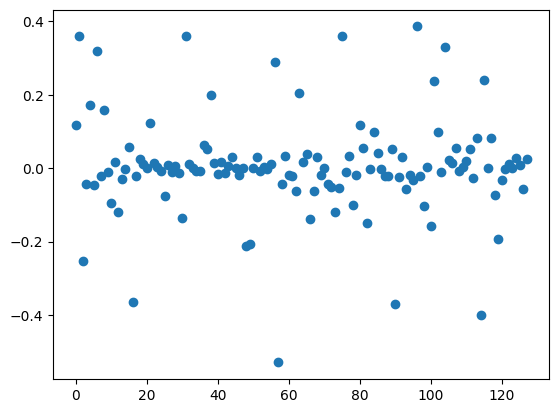

In [68]:
plt.plot(model.context[2].detach().numpy(), 'o')

In [24]:

for head in range(3):
    f1_scores = []
    accuracy_scores = []
    for i in range(4):
        f1_scores.append(all_results[head][i]['scores'])
        accuracy_scores.append(all_results[head][i]['accuracy_scores'])
        
    f1_scores = np.round(f1_scores, 2).mean()
    accuracy_scores = np.round(accuracy_scores, 2).mean()
    print(f1_scores, accuracy_scores)


0.5650000000000001 0.8075
0.65 0.84
0.5 0.8925


In [31]:
import numpy as np

f1_scores = []
accuracy_scores = []

    
for random_seed in range(n_models):
    f1_scores.append(all_results[random_seed]['scores'])
    accuracy_scores.append(all_results[random_seed]['accuracy_scores'])


In [32]:
f1_scores = np.mean(f1_scores, axis=0)
np.round(f1_scores, 2)

array([0.52, 0.56, 0.44])

In [33]:
accuracy_scores = np.mean(accuracy_scores, axis=0)
np.round(accuracy_scores, 2)

array([0.86, 0.73, 0.73])

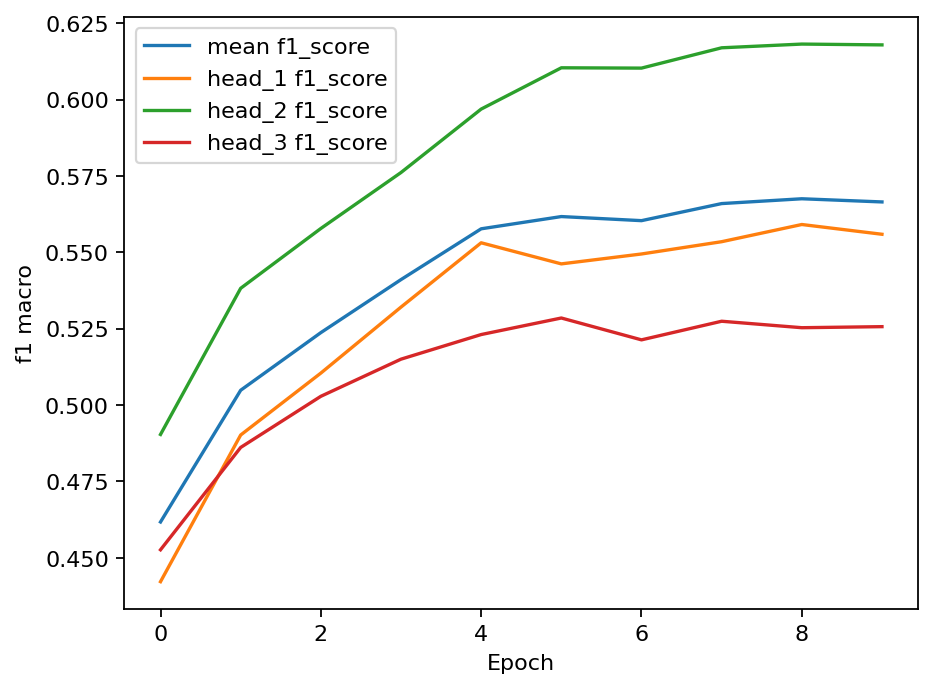

In [106]:
values = []

plt.figure(dpi=160)

for i in range(n_models):
    plot_data = pd.read_csv(f'Plots/run-version_{15 + i}-tag-f1_score_mean.csv')
    values.append(plot_data['Value'].values)
    
    
values = np.mean(values, axis=0)
plt.plot(values, label='mean f1_score')

for j in range(3):
    values = []
    for i in range(4):
        plot_data = pd.read_csv(f'Plots/run-version_{15 + i}-tag-f1_score_head_{j}.csv')
        values.append(plot_data['Value'].values)
        
    values = np.mean(values, axis=0)
    plt.plot(values, label=f'head_{j + 1} f1_score')


plt.xlabel('Epoch')
plt.ylabel('f1 macro')
plt.legend()

In [ ]:
all_results = {}
is_balanced = False
all_results['is_balanced'] = is_balanced
    
for seed_value in [2, 3, 4, 5]:
    main_data = pd.read_csv('data/is_ethicity_superior_meaning|is_ethicity_aggressor_meaning|is_ethicity_dangerous_meaning_eth_group_lemm_text.csv')
    all_results[seed_value] = {}
    for stage in np.unique(main_data['stage'].values):
        all_results[seed_value][stage] = {}
        for assessor in np.unique(main_data['assessor'].values):
            all_results[seed_value][stage][assessor] = {}
            seed_all(seed_value)

            curr_results = {}

            data = pd.read_csv('data/is_ethicity_superior_meaning|is_ethicity_aggressor_meaning|is_ethicity_dangerous_meaning_eth_group_lemm_text.csv')
            data = data[data['stage'] == stage]
            data = data[data['assessor'] == assessor]
            print(len(data))
    
            data['text_len'] = [len(text.split()) for text in data['lemm_text']]
            data, encoders, labels = encode_columns(data, column_to_encode)
            
            if not is_classes_whole(data, labels):
                clear_output(wait=True)
                continue
            
            max_len = np.max(data['text_len'])
            vocabulary, tokenized_column = Tokenize(data['lemm_text'], max_len)
            embedding_matrix = get_embedding_matrix(vocabulary)

            X = tokenized_column
            y = data[labels].values
            
            VOCAB_SIZE = len(navec.vocab.words) + 1
            EMBEDDING_DIM = 300
            
     
            train_loader, valid_loader, test_loader = get_dataloaders(X, y,
                                                    is_balanced=is_balanced, seed_value=seed_value)


            model = LSTMModel(input_dim=100, labels=cols, head_dims=[3, 3, 3])
            model.embedding.weight.data.copy_(torch.from_numpy(embedding_matrix))
            model.embedding.weight.requires_grad = True

            trainer = pl.Trainer(max_epochs=10, callbacks=[early_stop_callback])
            trainer.fit(model=model, train_dataloaders=train_loader, val_dataloaders=valid_loader)

            model.eval()
#             model.cuda()

            scores = get_predictions(model, test_loader)

            all_results[seed_value][stage][assessor] = scores
            clear_output(wait=True)
    
    with open(f'all_resiults{seed_value}.p', 'wb') as fp:
        pickle.dump(all_results, fp, protocol=pickle.HIGHEST_PROTOCOL)
    

3289


/tmp/ipykernel_624465/1951240.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for word, token in tqdm_notebook(vocabulary):


  0%|          | 0/10868 [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type       | Params
-----------------------------------------
0 | embedding | Embedding  | 150 M 
1 | lstm      | LSTM       | 220 K 
2 | attention | Attention  | 66.0 K
3 | fc2       | Linear     | 8.3 K 
4 | heads     | ModuleList | 585   
5 | dropout   | Dropout    | 0     
6 | relu      | ELU        | 0     
-----------------------------------------
150 M     Trainable params
0         Non-trainable params
150 M     Total params
601.184   Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

In [108]:
import pickle

In [30]:
# with open('all_resiults1.p', 'wb') as fp:
#     pickle.dump(all_results, fp, protocol=pickle.HIGHEST_PROTOCOL)

In [109]:
all_results = []

for i in range(1, 5):
    with open(f'all_resiults{i}.p', 'rb') as fp:
        x = pickle.load(fp)
        all_results.append(x)

In [114]:
all_results = all_results[-1]

In [121]:
import numpy as np

names = []
f1_scores_average = []

for stage in all_results[1].keys():
    for assessor in all_results[1][stage].keys():
        scores = []
        for random_seed in range(1, 5):
            res_ = all_results[random_seed][stage][assessor].get('scores', None)
            if res_ is not None:
                scores.append(res_)
        
        if len(scores) > 0:
            names.append(f'{stage} {assessor[0]}...{assessor[-1]}')
#             print(stage, assessor)
            scores = np.array(scores)
            f1_scores_average.append(scores.mean())
#             print(scores.mean(axis=0))

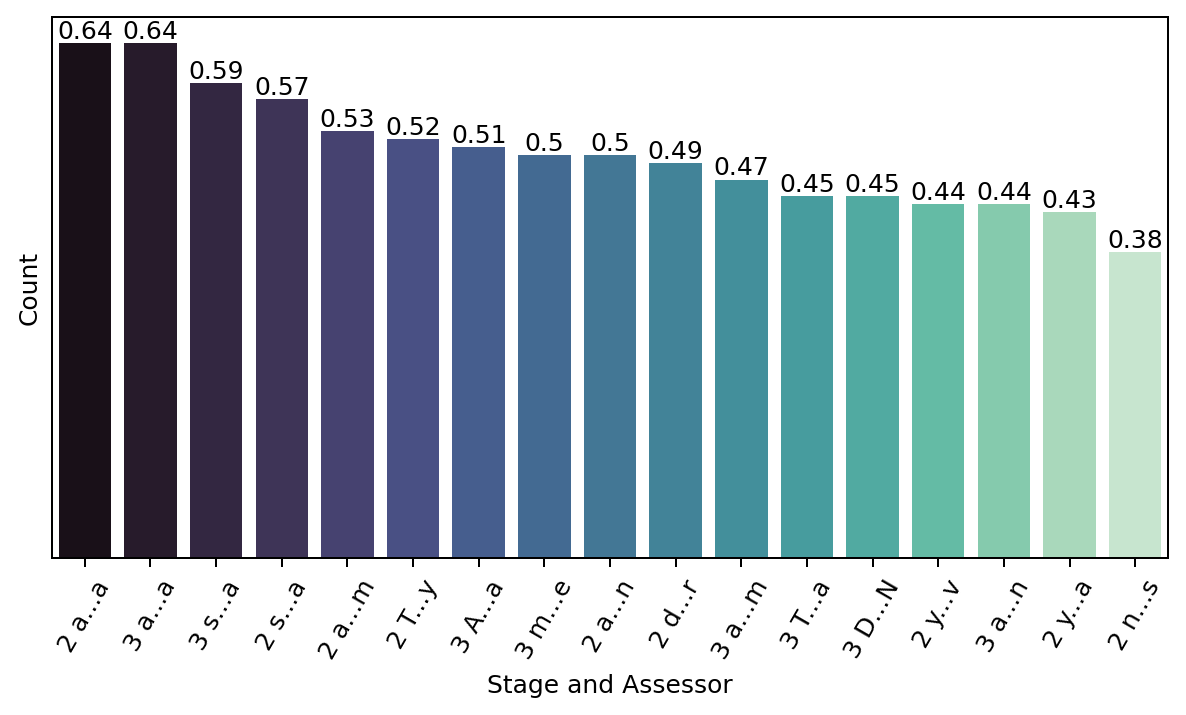

In [122]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8,3.9), dpi=180)

f1_scores_average = np.array(f1_scores_average)
order = np.argsort(-f1_scores_average)
names = np.array(names)[order]
f1_scores_average = np.round(f1_scores_average, 2)[order]

ax = sns.barplot(x=names, y=f1_scores_average, palette='mako')
# plt.title('Average f1_score macro', fontsize=14)
plt.yticks([])
ax.bar_label(ax.containers[0])
plt.ylabel('Count')
plt.xlabel('Stage and Assessor')
plt.xticks(rotation=60)
plt.show()